<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/NGC_6913/NGC_6913_version_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Packages and download the csv files

#### Importing packages

In [1]:
# import packages
import pandas as pd
import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for downloading file
from google.colab import files

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestClassifier

In [2]:
!pip install astroquery

     |████████████████████████████████| 6.5MB 4.6MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 2.6MB 49.8MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=5ab61661eb8070e78861b0b4f4371c5e5c262a9371a9cff27138bbaa52fa9c6d
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery


In [3]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [16]:

for table in (Gaia.load_tables()):
    print(table.name)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.apassdr9
external.gaiadr2_geometric_distance
external.galex_ais
external.ravedr5_com
external.ravedr5_dr5
external.ravedr5_gra
external.ravedr5_on
external.sdssdr13_photoprimary
external.skymapperdr1_master
external.skymapperdr2_master
external.tmass_xsc
public.hipparcos
public.hipparcos_newreduction
public.hubble_sc
public.igsl_source
public.igsl_source_catalog_ids
public.tycho2
public.dual
tap_config.coord_sys
tap_config.properties
tap_schema.columns
tap_schema.key_columns
tap_schema.keys
tap_schema.schemas
tap_schema.tables
gaiaedr3.gaia_source
gaiaedr3.agn_cross_id
gaiaedr3.commanded_scan_law
gaiaedr3.dr2_neighbourhood
gaiaedr3.frame_rotator_source
gaiaedr3.hipparcos2_best_neighbour
gaiaedr3.hipparcos2_neighbourhood
gaiaedr3.panstarrs1_best_neighbour
gaiaedr3.panstarrs1_join
gaiaedr3.panstarrs1_neighbourhood
gaiaedr3.sdssdr13_be

In [19]:
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coordinate, radius, table_name="gaiaedr3.gaia_source")
r = j.get_results()
r.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,...,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist
0,1636042515805110273,Gaia EDR3 2061130135063018368,2061130135063018368,1235786448,2016.0,305.979909,0.236415,38.522534,0.237248,0.397334,0.295945,1.342594,8.972993,-5.024802,0.312876,-7.434108,0.301987,-0.002054,-0.021876,-0.139199,0.081767,0.177127,0.071293,-0.089437,-0.112233,-0.109826,0.064854,361,0,360,1,-0.164099,387.622772,0.204746,0.060639,95,False,NaN,1.210119,0.072792,...,-102.076408,62.934090,-1.807701,-2.746920,False,374,261.826048,0.791048,330.986298,19.642334,28,39.116955,5.693171,6.870856,21.357630,34,353.218535,6.189018,57.071823,18.377787,0,0,0,0,0,1.498459,2.979843,1.715296,1.264547,NaN,NaN,0,NaN,NaN,NaN,76.913311,0.606578,324.067660,55.412832,0.002803
1,1636042515805110273,Gaia EDR3 2061130169422135168,2061130169422135168,590633777,2016.0,305.986649,0.486809,38.524910,0.519892,0.027887,0.653152,0.042696,5.194105,-3.340347,0.670370,-3.977537,0.776949,-0.100407,-0.270446,0.073397,0.162304,0.134663,0.147002,-0.032557,-0.026625,0.055117,0.020644,288,0,288,0,1.782572,360.009552,2.161939,1.948813,95,False,NaN,1.244244,0.141224,...,-111.709290,82.712280,-3.610998,-6.607189,False,289,138.288473,0.887084,155.891022,20.335402,22,42.109223,6.678684,6.305018,21.277599,32,174.021279,10.474254,16.614193,19.146389,0,0,0,0,0,1.562896,2.131210,0.942198,1.189013,NaN,NaN,0,NaN,NaN,NaN,76.918285,0.603627,324.077847,55.412826,0.003027
2,1636042515805110273,Gaia EDR3 2061130173719911552,2061130173719911552,877811672,2016.0,305.987775,1.427762,38.525852,1.533135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,0,98,0,0.523010,99.617256,1.230538,0.129681,3,False,NaN,NaN,NaN,...,-72.359871,-74.190239,19.085051,-4.887089,False,107,83.627050,1.379328,60.628857,20.881500,2,9.433291,10.864990,0.868228,22.901884,9,111.880554,12.236165,9.143433,19.626009,0,0,0,0,1,1.450653,3.275875,2.020384,1.255491,NaN,NaN,0,NaN,NaN,NaN,76.919562,0.603446,324.079945,55.413321,0.004284
3,1636042515805110273,Gaia EDR3 2061130135061358080,2061130135061358080,874528988,2016.0,305.977852,0.126111,38.523700,0.144917,0.394372,0.170267,2.316196,6.338911,-3.255364,0.174165,-5.439154,0.194204,-0.068859,-0.079560,-0.092471,0.049970,0.122616,0.064729,-0.004315,-0.027884,-0.086002,0.010300,398,0,398,0,1.212380,468.469330,0.632258,1.821308,95,False,NaN,1.278599,0.041333,...,-65.782684,75.814346,10.441344,-7.248068,False,403,568.842760,1.124688,505.778198,18.799887,45,110.415813,6.370686,17.331858,20.230965,45,704.393817,7.347003,95.874985,17.628357,0,0,0,2,0,1.432399,2.602608,1.431078,1.171530,NaN,NaN,0,NaN,NaN,NaN,76.913340,0.608565,324.065920,55.414556,0.004309
4,1636042515805110273,Gaia EDR3 206113016

#### Finding GAIA Data

In [28]:
## making a GAIA cone_search of 30m radius around NGC6913 center

coordinate = coord.SkyCoord.from_name('NGC6913')
print(coordinate)
radius = u.Quantity(0.8, u.deg)
# GAIA EDR3 data
# j = Gaia.cone_search_async(coordinate, radius, table_name="gaiaedr3.gaia_source")

# GAIA DR2 Data
j = Gaia.cone_search_async(coordinate, radius, table_name="gaiadr2.gaia_source")
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (305.98333333, 38.52333333)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [29]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
0,1635721458409799680,Gaia DR2 2061130135063018368,2061130135063018368,659634151,2015.5,305.979910,0.332861,38.522535,0.301018,0.373794,0.412532,0.906096,-5.100601,0.812966,-8.181460,0.579568,-0.017581,0.084075,0.098068,0.034593,0.372245,0.010567,-0.133693,-0.021647,0.017277,0.016911,242,0,241,1,2.371331,290.591705,0.973766,1.042753e+00,31,False,0.092856,1.314335,0.090345,-0.025863,...,374.200125,6.729877,55.602821,18.329161,1.700114,0,2.624422,1.276796,1.347626,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.913312,0.606578,324.067662,55.412832,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.002802
1,1635721458409799680,Gaia DR2 2061130169422135168,2061130169422135168,1047410342,2015.5,305.986649,0.551148,38.524911,0.562689,-0.757284,0.713565,-1.061268,-4.351111,1.294378,-4.469651,1.147469,-0.314511,-0.306406,-0.143730,0.110184,0.285002,0.082362,-0.386891,0.024789,0.077053,-0.019642,214,0,213,1,2.072794,252.446564,0.397076,6.260261e-02,31,False,0.039263,1.379358,0.144610,0.042972,...,195.589708,10.444030,18.727419,19.033554,1.842011,0,2.083460,0.738298,1.345161,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.918285,0.603627,324.077848,55.412826,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.003028
2,1635721458409799680,Gaia DR2 2061130173719911552,2061130173719911552,1630697475,2015.5,305.987777,1.436923,38.525853,1.461241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88,0,88,0,-1.281829,66.976456,0.000000,0.000000e+00,3,False,0.013401,NaN,NaN,0.052217,...,110.490162,15.678766,7.047121,19.653610,2.215422,0,1.295437,-0.038664,1.334101,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.919563,0.603446,324.079948,55.413321,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.004285
3,1635721458409799680,Gaia DR2 2061130135061358080,2061130135061358080,1539788148,2015.5,305.977852,0.159351,38.523700,0.167229,0.232010,0.214437,1.081950,-3.257656,0.385975,-5.809052,0.344036,-0.101113,-0.028410,-0.068365,0.028975,0.305656,0.019233,-0.077661,-0.029386,0.035019,0.039842,263,0,262,1,1.800683,299.285553,0.564693,1.225498e+00,31,False,0.305587,1.323049,0.046636,0.036019,...,712.860518,10.730518,66.433006,17.629408,1.514112,0,2.449070,1.252272,1.196798,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.913341,0.608565,324.065922,55.414556,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.004309
4,1635721458409799680,Gaia DR2 2061130169422134016,2061130169422134016,1167108254,2015.5,305.98894

##### Applying Filter:

In [30]:
all_stars['pmra_over_error'] = abs(all_stars['pmra']/all_stars['pmra_error'])
all_stars['pmdec_over_error'] = abs(all_stars['pmdec']/all_stars['pmdec_error'])

In [31]:
all_stars_filtered = all_stars[all_stars['parallax_over_error'] > 3]

In [32]:
all_stars_filtered = all_stars_filtered[(all_stars_filtered['pmdec_over_error'] > 3) & (all_stars_filtered['pmra_over_error'] > 3)]

In [33]:
all_stars_filtered.shape

(28034, 99)

##### Visualizing GAIA data

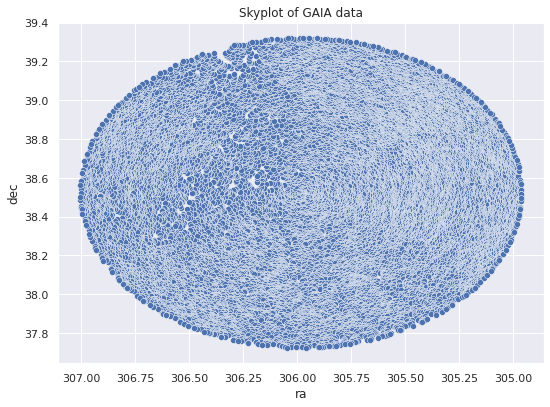

In [34]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', 
                          data = all_stars_filtered)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

#### Finding Cantat Data

In [35]:
#### Finding Cantat catalogue

catalog_list = Vizier.find_catalogs('Cantat')
{k:v.description for k,v in catalog_list.items()}

{'I/349': 'StarHorse, Gaia DR2 photo-astrometric distances (Anders+, 2019)',
 'J/A+A/561/A94': 'Velocities and photometry in Trumpler 20 (Donati+, 2014)',
 'J/A+A/564/A133': 'Gaia FGK benchmark stars: metallicity (Jofre+, 2014)',
 'J/A+A/569/A17': 'Gaia-ESO Survey: NGC6705 (Cantat-Gaudin+, 2014)',
 'J/A+A/582/A81': 'Gaia FGK benchmark stars: abundances (Jofre+, 2015)',
 'J/A+A/588/A120': 'Equivalent widths in 10 open clusters (Cantat-Gaudin+, 2016)',
 'J/A+A/591/A37': 'Gaia-ESO Survey. Parameters for cluster members (Jacobson+, 2016)',
 'J/A+A/597/A10': 'South Ecliptic Pole stars radial velocities (Fremat+, 2017)',
 'J/A+A/598/A68': 'Gaia-ESO Survey. Trumpler 23 (Overbeek+, 2017)',
 'J/A+A/601/A19': 'Gaia DR1 open cluster members (Gaia Collaboration+, 2017)',
 'J/A+A/603/A2': 'Gaia-ESO Survey abundances radial distribution (Magrini+, 2017)',
 'J/A+A/605/A79': 'TGAS Cepheids and RR Lyrae stars (Gaia Collaboration+, 2017)',
 'J/A+A/615/A49': 'TGAS stars membership in 128 open clusters (C

In [36]:
## cheking the tables in the GAIA DR2 paper

Vizier.ROW_LIMIT = -1
#catalogs = Vizier.get_catalogs(catalog_list['J/A+A/633/A99'])
#catalogs

In [37]:
## saving only NGC 6913 data from Cantat GAIA DR2 paper

cantat_6913 = Vizier(catalog = 'J/A+A/633/A99/members', row_limit = -1).query_constraints(Cluster="NGC_6913")
cantat_6913 = cantat_6913[0].to_pandas()
cantat_6913

,RA_ICRS,DE_ICRS,Source,Plx,pmRA,pmDE,RV,Gmag,BP-RP,Proba,Cluster,_RA.icrs,_DE.icrs
0,305.969238,38.303085,2061114643120061952,0.5934,-3.488,-5.897,NaN,15.447200,1.6735,0.8,NGC_6913,305.969258,38.303110
1,305.871156,38.486870,2061130551679058432,0.5344,-3.476,-5.747,NaN,14.504200,1.0105,0.8,NGC_6913,305.871175,38.486895
2,305.916894,38.295450,2061115021077207296,0.5359,-3.500,-5.608,NaN,15.938500,1.7948,0.4,NGC_6913,305.916914,38.295474
3,305.943575,38.655508,2061158176909306496,0.5496,-3.072,-5.630,NaN,13.786300,1.3860,0.7,NGC_6913,305.943591,38.655532
4,305.729983,38.379210,2061125363358595200,0.5688,-3.459,-5.879,NaN,14.523400,1.3140,1.0,NGC_6913,305.730002,38.379235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,305.693412,38.581854,2061180579450262656,0.5195,-3.086,-6.098,NaN,16.030199,1.6694,0.1,NGC_6913,305.693429,38.581881
166,305.710603,38.650615,2061181571589836544,0.5638,-3.211,-5.658,NaN,17.743799,1.9652,0.5,NGC_6913,305.710621,38.650640
167,305.830998,38.732448,2061206413680783488,0.4924,-3.305,-5.605,NaN,17.912500,2.3891,0.2,NGC_6913,305.831016,38.732472
168,306.214730,38.283003,2058109815277535616,0.5582,-3.076,-5.901,NaN,16.621000,2.3549,0.1,NGC_6913,306.214747,38.283028


In [38]:
# renaming the cantat table to match it with gaia_data
cantat_6913 = cantat_6913.rename(columns={'Source':'source_id',
                                          'Proba':'PMemb'})


In [39]:
# taking the subset of only source_id and PMemb
cantat_6913 = cantat_6913.loc[:,['source_id', 'PMemb']]


In [40]:
# join the two table on source_id
cantat_6913 = all_stars_filtered.join(cantat_6913.set_index('source_id'), on='source_id')

In [41]:
# dropping the rows, where we don't have PMemb 
# (i.e. the source id was not in the cantat table)
cantat_6913 = cantat_6913.dropna(subset=['PMemb'])
cantat_6913

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb
29,1635721458409799680,Gaia DR2 2061130139362333824,2061130139362333824,954418691,2015.5,305.990473,0.013010,38.514351,0.014309,0.542993,0.017657,30.752131,-3.402550,0.029173,-5.793631,0.029298,-0.121473,0.013768,-0.120340,-0.001874,0.249431,-0.026708,-0.117860,-0.100446,-0.117522,-0.106875,275,0,275,0,-4.420243,179.250107,0.000000,0.000000,31,False,68.874550,1.517808,0.003702,0.051634,...,13.131310,1.262399,1,1.257004,0.546887,0.710116,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.911361,0.595112,324.074993,55.401971,100002,4813.937012,4715.242676,4982.020020,NaN,NaN,NaN,NaN,NaN,NaN,200111,4.187072,3.909311,4.364184,8.482368,7.701898,9.262839,https://gea.esac.esa.int/data-server/datalink/...,,0.010579,116.632893,197.746675,0.9
39,1635721458409799680,Gaia DR2 2061130173722072320,2061130173722072320,1141266204,2015.5,305.998644,0.033662,38.527390,0.022625,0.507027,0.034273,14.793980,-3.190718,0.081669,-5.637011,0.045854,-0.146535,-0.394684,0.417441,0.130678,0.264738,-0.031606,-0.128072,-0.211356,-0.191511,0.091486,197,0,196,1,-1.613617,160.571564,0.000000,0.000000,31,False,21.751890,1.494739,0.007018,0.083249,...,14.249866,1.320299,0,1.387800,0.584863,0.802938,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.925706,0.597371,324.094710,55.411221,100001,4492.000000,4425.500000,4906.000000,NaN,NaN,NaN,NaN,NaN,NaN,200111,3.112038,2.608971,3.206267,3.552577,2.987486,4.117669,https://gea.esac.esa.int/data-server/datalink/...,,0.012639,39.068763,122.933351,0.7
59,1635721458409799680,Gaia DR2 2061130070642666880,2061130070642666880,1477295721,2015.5,305.989576,0.021783,38.509626,0.021940,0.537889,0.028150,19.107899,-3.441772,0.044039,-5.877576,0.043456,-0.133816,0.108276,-0.140303,-0.061589,0.237611,-0.103821,-0.083638,-0.247389,-0.068452,-0.057484,248,248,247,1,0.012927,241.617935,0.000000,0.000000,31,True,240.833008,1.551702,0.006401,0.109116,...,11.969657,1.245247,0,1.129319,0.480597,0.648722,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.907090,0.592971,324.070442,55.397954,100001,4938.652344,4866.310059,5085.106934,NaN,NaN,NaN,NaN,NaN,NaN,200111,6.942542,6.548400,7.150491,25.832445,23.617132,28.047758,https://gea.esac.esa.int/data-server/datalink/...,,0.014555,78.151991,135.253726,1.0
81,1635721458409799680,Gaia DR2 2061130100701594752,2061130100701594752,1037082205,2015.5,305.998585,0.070253,38.510091,0.079943,0.526576,0.095286,5.526245,-3.564348,0.164491,-5.650762,0.176258,-0.126325,0.011177,-0.093192,0.009505,0.082709,-0.016679,-0.284162,-0.148596,0.030191,-0.072290,247,0,247,0,2.805028,308.320526,0.354874,2.568195,31,False,1.535858,1.357920,0.020578,0.124196,...,16.305899,1.429119,0,2.239937,1.140545,1.099392,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.911521,0.587468,324.082092,55.395476,<NA>,NaN,NaN,NaN,NaN,NaN,N

In [42]:
# saving both cantat and Gaia files as csv
# if you want to save, comment out the next two lines

cantat_6913.to_csv('NGC_6913_cantat.csv')
# all_stars.to_csv('NGC_6913_Gaia_30m.csv')

In [43]:
cantat_6913.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb
count,1.700000e+02,1.700000e+02,1.700000e+02,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,1.690000e+02,169.000000,169.000000,169.000000,169.000000,170.000000,169.000000,169.000000,169.000000,1.000000,1.000000,170.000000,1.0,1.0,1.0,170.000000,170.000000,170.000000,170.000000,145.000000,145.000000,145.000000,145.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,144.0,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,170.000000,170.000000,170.000000,170.000000
mean,1.635721e+18,2.061104e+18,8.991247e+08,2015.5,305.916874,0.030140,38.498505,0.036322,0.549987,0.041139,18.595560,-3.380745,0.067076,-5.764726,0.074174,-0.052862,0.047154,-0.138174,-0.051963,0.178949,-0.087508,-0.279096,-0.162469,-0.028793,-0.032876,261.029412,31.388235,259.623529,1.405882,-0.452034,251.052277,0.048083,0.398448,31.0,57.397316,1.461027,0.009230,0.062775,29.729412,16.105882,...,7.444622e+04,113.394450,690.067383,14.236567,1.320751,0.176471,1.606532,0.757240,0.849291,-17.989237,5.377616,0.035294,5000.0,3.0,0.0,76.865400,0.633193,323.971153,55.411141,100001.193103,4521.335938,4340.726562,4858.288574,2.151746,1.871649,2.629261,1.076579,0.928603,1.343582,200111.0,4.154220,3.680255,4.482897,15.790257,14.470527,17.109993,0.155467,71.419562,110.971035,0.561765
std,0.000000e+00,3.270528e+14,4.883002e+08,0.0,0.142852,0.021423,0.125399,0.026414,0.031147,0.028844,8.643813,0.162431,0.048570,0.184031,0.055731,0.074475,0.128318,0.103372,0.062765,0.135922,0.061610,0.135682,0.085144,0.094080,0.076245,22.651574,86.893881,22.167718,2.222790,3.340387,79.192787,0.099826,1.263057,0.0,97.824677,0.079588,0.006703,0.040093,2.543762,0.979355,...,3.264491e+05,603.299153,393.197235,1.571638,0.072689,0.397521,0.452540,0.271826,0.183238,NaN,NaN,0.460179,NaN,NaN,NaN,0.113765,0.123647,0.190410,0.128638,0.396102,556.623779,550.933777,521.955872,0.770660,0.725869,0.540000,0.391130,0.365506,0.281625,0.0,3.504805,3.357561,3.662597,61.949299,57.375221,66.523674,0.085152,33.970233,51.393213,0.257680
min,1.635721e+18,2.058110e+18,1.723005e+06,2015.5,305.636921,0.011508,38.261299,0.013074,0.479977,0.015596,3.813220,-3.740193,0.025444,-6.255921,0.027417,-0.256366,-0.394684,-0.369383,-0.213974,-0.214332,-0.228630,-0.749702,-0.336544,-0.197922,-0.274328,197.000000,0.000000,196.000000,0.000000,-8.638947,106.939201,0.000000,0.000000,31.0

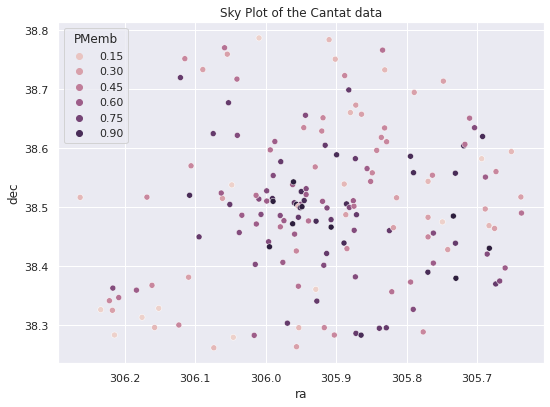

In [44]:
## plotting the skyplot 

skyplot = sns.scatterplot(x = cantat_6913['ra'], y = cantat_6913['dec'], 
                          hue = cantat_6913['PMemb'])
skyplot.invert_xaxis()
plt.title('Sky Plot of the Cantat data')
plt.show()

### Creating, Examining and Processing the Training Data


#### Training Data

In [45]:
# import member dataset
member = cantat_6913.copy()

In [46]:
### adding their distance from the center of the clusters

## NGC 6913
center = coord.SkyCoord.from_name('NGC6913')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((member['ra'] - center_ra)*np.cos(np.radians(member['dec'])))**2 + (member['dec'] - center_dec)**2 )
member['dist_6913_center'] = distance

In [47]:
# maximum distance of stars in Cantat Data
cantat_radius = max(member.dist_6913_center)

In [48]:
member['member'] = np.full(len(member), 1)
member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb,dist_6913_center,member
29,1635721458409799680,Gaia DR2 2061130139362333824,2061130139362333824,954418691,2015.5,305.990473,0.013010,38.514351,0.014309,0.542993,0.017657,30.752131,-3.402550,0.029173,-5.793631,0.029298,-0.121473,0.013768,-0.120340,-0.001874,0.249431,-0.026708,-0.117860,-0.100446,-0.117522,-0.106875,275,0,275,0,-4.420243,179.250107,0.000000,0.000000,31,False,68.874550,1.517808,0.003702,0.051634,...,1,1.257004,0.546887,0.710116,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.911361,0.595112,324.074993,55.401971,100002,4813.937012,4715.242676,4982.020020,NaN,NaN,NaN,NaN,NaN,NaN,200111,4.187072,3.909311,4.364184,8.482368,7.701898,9.262839,https://gea.esac.esa.int/data-server/datalink/...,,0.010579,116.632893,197.746675,0.9,0.010578,1
39,1635721458409799680,Gaia DR2 2061130173722072320,2061130173722072320,1141266204,2015.5,305.998644,0.033662,38.527390,0.022625,0.507027,0.034273,14.793980,-3.190718,0.081669,-5.637011,0.045854,-0.146535,-0.394684,0.417441,0.130678,0.264738,-0.031606,-0.128072,-0.211356,-0.191511,0.091486,197,0,196,1,-1.613617,160.571564,0.000000,0.000000,31,False,21.751890,1.494739,0.007018,0.083249,...,0,1.387800,0.584863,0.802938,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.925706,0.597371,324.094710,55.411221,100001,4492.000000,4425.500000,4906.000000,NaN,NaN,NaN,NaN,NaN,NaN,200111,3.112038,2.608971,3.206267,3.552577,2.987486,4.117669,https://gea.esac.esa.int/data-server/datalink/...,,0.012639,39.068763,122.933351,0.7,0.012646,1
59,1635721458409799680,Gaia DR2 2061130070642666880,2061130070642666880,1477295721,2015.5,305.989576,0.021783,38.509626,0.021940,0.537889,0.028150,19.107899,-3.441772,0.044039,-5.877576,0.043456,-0.133816,0.108276,-0.140303,-0.061589,0.237611,-0.103821,-0.083638,-0.247389,-0.068452,-0.057484,248,248,247,1,0.012927,241.617935,0.000000,0.000000,31,True,240.833008,1.551702,0.006401,0.109116,...,0,1.129319,0.480597,0.648722,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.907090,0.592971,324.070442,55.397954,100001,4938.652344,4866.310059,5085.106934,NaN,NaN,NaN,NaN,NaN,NaN,200111,6.942542,6.548400,7.150491,25.832445,23.617132,28.047758,https://gea.esac.esa.int/data-server/datalink/...,,0.014555,78.151991,135.253726,1.0,0.014552,1
81,1635721458409799680,Gaia DR2 2061130100701594752,2061130100701594752,1037082205,2015.5,305.998585,0.070253,38.510091,0.079943,0.526576,0.095286,5.526245,-3.564348,0.164491,-5.650762,0.176258,-0.126325,0.011177,-0.093192,0.009505,0.082709,-0.016679,-0.284162,-0.148596,0.030191,-0.072290,247,0,247,0,2.805028,308.320526,0.354874,2.568195,31,False,1.535858,1.357920,0.020578,0.124196,...,0,2.239937,1.140545,1.099392,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.911521,0.587468,324.082092,55.395476,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.

In [49]:
### adding their distance from the center of the clusters

## NGC 6913
center = coord.SkyCoord.from_name('NGC6913')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((all_stars_filtered['ra'] - center_ra)*np.cos(np.radians(all_stars_filtered['dec'])))**2 + (all_stars_filtered['dec'] - center_dec)**2 )
all_stars_filtered['dist_6913_center'] = distance

In [50]:
non_member = all_stars_filtered[all_stars_filtered['dist_6913_center'] >= 0.7].sample(len(member), random_state = 42)

In [51]:
non_member['member'] = np.full(len(non_member), 0)
non_member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,dist_6913_center,member
130087,1635721458409799680,Gaia DR2 2061389074352618240,2061389074352618240,471233619,2015.5,305.149317,0.035223,38.942651,0.047496,0.382323,0.050591,7.557175,-2.516003,0.084044,-5.653831,0.088506,-0.144035,-0.096192,0.027363,-0.009399,0.275601,-0.087917,-0.245573,-0.188112,0.009692,-0.045207,236,0,235,1,0.478309,239.725876,0.0,0.0,31,False,5.734736,1.477974,0.011819,-0.003636,...,1.313776,0,1.513396,0.676708,0.836688,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.888496,1.378381,323.325096,56.062095,100001,4414.000000,4298.000000,4483.926758,3.0075,2.6359,3.172,1.5207,1.2373,1.6383,200111,2.338716,2.266340,2.466660,1.870591,1.327614,2.413569,https://gea.esac.esa.int/data-server/datalink/...,,0.774009,29.936813,63.880964,0.772405,0
125050,1635721458409799680,Gaia DR2 2061388902553713792,2061388902553713792,1156787144,2015.5,305.145155,0.046004,38.910134,0.062217,0.298180,0.066671,4.472388,-4.965713,0.104837,-7.442619,0.116313,-0.108424,-0.003355,-0.084432,-0.066317,0.254677,-0.149928,-0.179994,-0.258665,0.069831,-0.040100,255,0,254,1,0.586445,261.628052,0.0,0.0,31,False,3.028944,1.413125,0.015559,0.038247,...,1.401361,0,1.948131,0.928505,1.019626,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,76.859867,1.362612,323.295937,56.033764,100001,3834.159912,3738.000000,4059.652588,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.759808,47.365858,63.988047,0.758286,0
126382,1635721458409799680,Gaia DR2 2061395946300274944,2061395946300274944,726533435,2015.5,305.297987,0.029740,39.069026,0.034124,0.538368,0.042471,12.676241,-5.486846,0.068902,-10.842330,0.068120,-0.147621,-0.152390,-0.043840,0.028951,0.373847,-0.053051,-0.037938,-0.229564,0.017545,-0.022325,248,0,245,3,-0.100945,237.133240,0.0,0.0,31,False,9.224349,1.471230,0.008439,-0.006630,...,1.330767,0,1.634588,0.749080,0.885509,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,77.058165,1.355003,323.607064,56.129768,100001,4246.333496,4138.799805,4367.250000,NaN,NaN,NaN,NaN,NaN,NaN,200111,2.308709,2.182636,2.430237,1.561312,1.283448,1.839175,https://gea.esac.esa.int/data-server/datalink/...,,0.763599,79.632700,159.166116,0.762171,0
106329,1635721458409799680,Gaia DR2 2061394228313558912,2061394228313558912,568325213,2015.5,305.389578,0.103744,39.053791,0.109299,0.631659,0.135256,4.670110,-3.333319,0.243423,-8.008529,0.227290,-0.152152,-0.034987,-0.130906,0.049660,0.367075,-0.008208,-0.289637,-0.149790,-0.201774,-0.194237,235,0,234,1,-0.260205,222.821121,0.0,0.0,31,False,0.860913,1.369794,0.027856,-0.012405,...,1.418306,0,1.793842,0.797436,0.996407,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,77.086084,1.287840,323.711962,56.086543,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.i

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


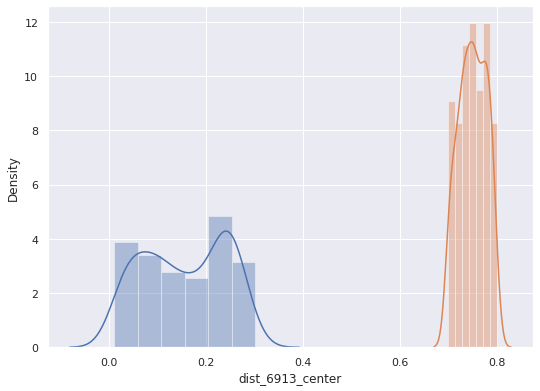

In [52]:
sns.distplot(member['dist_6913_center'])
sns.distplot(non_member['dist_6913_center'])
plt.show()

In [53]:
training_data = pd.concat([member, non_member])

In [54]:
# Examining the descriptive statistics of each column
training_data.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_6913_center,member
count,3.400000e+02,3.400000e+02,3.400000e+02,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,...,338.000000,338.000000,338.000000,340.000000,338.000000,338.000000,338.000000,7.000000,7.000000,340.000000,7.000000,7.000000,7.0,340.000000,340.000000,340.000000,340.000000,213.000000,213.000000,213.000000,213.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,197.0,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,340.000000,340.000000,340.000000,170.000000,340.000000,340.000000
mean,1.635721e+18,2.061395e+18,8.602186e+08,2015.5,305.898748,0.055617,38.517403,0.069339,0.703761,0.076313,15.453048,-2.717795,0.126444,-5.178777,0.138777,-0.049170,0.026374,-0.148459,-0.047572,0.189191,-0.083631,-0.297422,-0.143678,-0.025102,-0.032411,255.167647,17.891176,253.855882,1.311765,1.335481,313.581299,0.145981,2.276631,31.0,34.596348,1.425611,0.017110,0.050839,29.105882,15.941176,...,511.572449,15.099657,1.383454,0.129412,1.844503,0.894626,0.949876,-26.844435,3.937495,0.132353,4928.571289,3.285714,0.0,76.873609,0.656212,323.962214,55.433334,100010.572770,4454.589844,4273.145020,4774.999023,1.968735,1.714425,2.350685,0.986844,0.851938,1.196008,200111.0,4.082622,3.599111,4.396647,15.560237,14.136306,16.984173,0.452860,51.636766,81.820351,0.561765,0.452877,0.500000
std,0.000000e+00,1.779212e+15,5.025505e+08,0.0,0.515897,0.053115,0.361978,0.069118,0.505294,0.073657,13.394525,3.270804,0.127459,5.493028,0.139842,0.090065,0.139340,0.105245,0.069148,0.130580,0.072626,0.141846,0.094046,0.106565,0.090973,24.429022,66.128394,24.218398,1.779060,6.264415,377.609558,0.302371,11.061324,0.0,76.761337,0.089621,0.016646,0.046483,2.715729,1.014386,...,405.028076,1.788616,0.167116,0.353265,0.575206,0.380450,0.223975,27.513456,2.971805,0.985206,838.081726,0.566947,0.0,0.371088,0.395334,0.691899,0.373737,137.025685,576.338623,566.618408,556.079956,0.927303,0.886926,0.879321,0.469087,0.446917,0.451612,0.0,3.931473,3.652580,4.114880,64.727966,59.584225,69.883705,0.304462,38.657992,62.454650,0.257680,0.304480,0.500737
min,1.635721e+18,2.057999e+18,1.723005e+06,2015.5,304.975980,0.010598,37.753933,0.011981,0.257506,0.013775,3.044625,-18.840489,0.022903,-53.110874,0.024498,-0.331053,-0.394684,-0.440014,-0.213974,-0.214332,-0.250588,-0.749702,-0.374262,-0.320336,-0.303381,164.000000,0.000000,164.000000,0.000000,-8.638947,98.581345,0.00000

In [55]:
# Choosing the features

feature_columns = ['parallax',
                   'pmra', 'pmdec']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [56]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')


# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,parallax,pmra,pmdec
count,340.000000,340.000000,340.000000
mean,0.703761,-2.717795,-5.178776
std,0.505294,3.270804,5.493028
min,0.257506,-18.840488,-53.110874
25%,0.519026,-3.520556,-5.958104
50%,0.558384,-3.322860,-5.712452
75%,0.625977,-2.721688,-5.054229
max,4.235855,18.203505,32.391811


In [57]:
targets.value_counts()

1    170
0    170
Name: member, dtype: int64

#### Visualizing Training Data


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


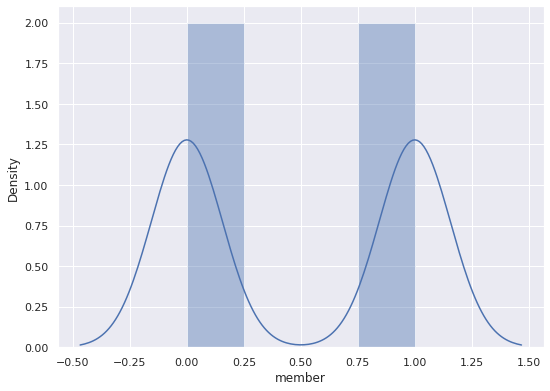

In [58]:
# histogram of PMemb in the training data
sns.distplot(training_set['member'])
plt.show()

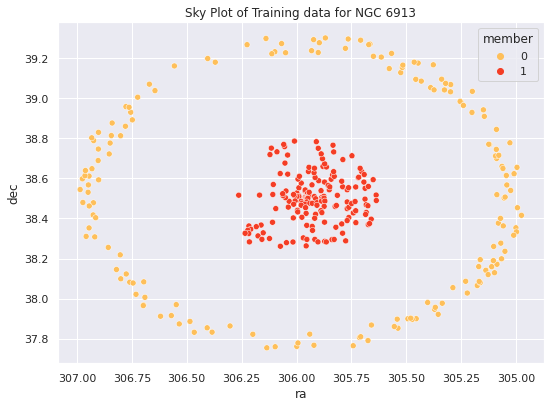

In [59]:
sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x = 'ra', y='dec', palette='YlOrRd', hue = 'member', data = training_data)
skyplot.invert_xaxis()
plt.title('Sky Plot of Training data for NGC 6913')
plt.show()

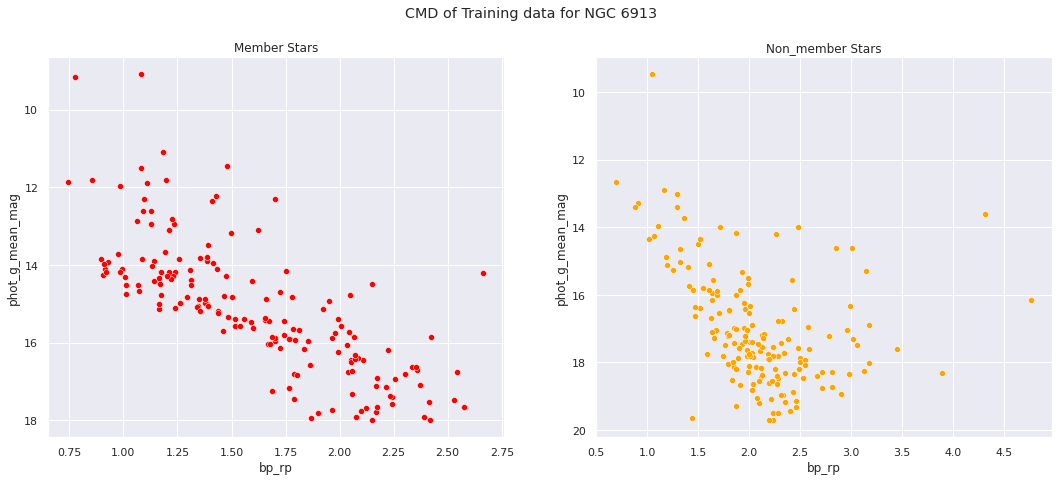

In [60]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)
#cmd = sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', hue = 'PMemb', data = training_data)
#cmd.invert_yaxis()
#plt.title('')
#plt.show()

# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.suptitle('CMD of Training data for NGC 6913 ')

sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
axes[0].invert_yaxis()

#plt.show()
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
axes[1].invert_yaxis()

plt.show()


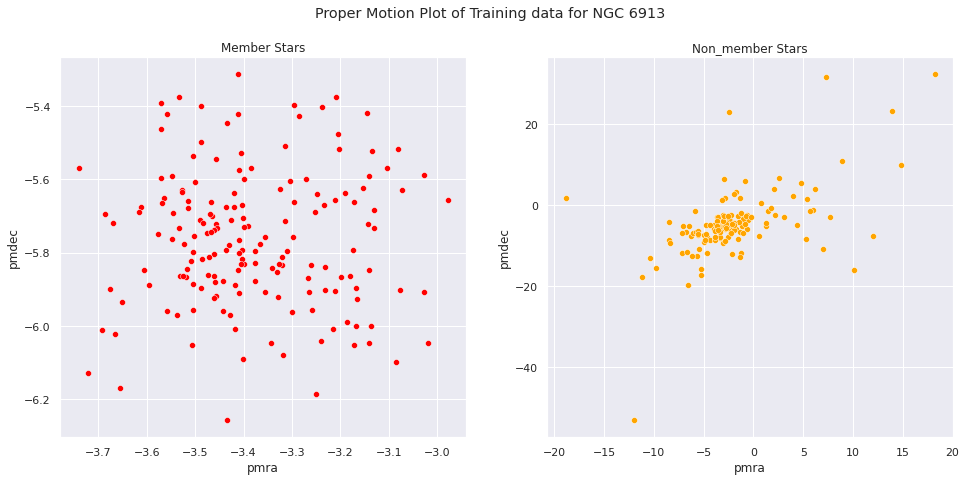

In [61]:
# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Proper Motion Plot of Training data for NGC 6913 ')

sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
#plt.show()
sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


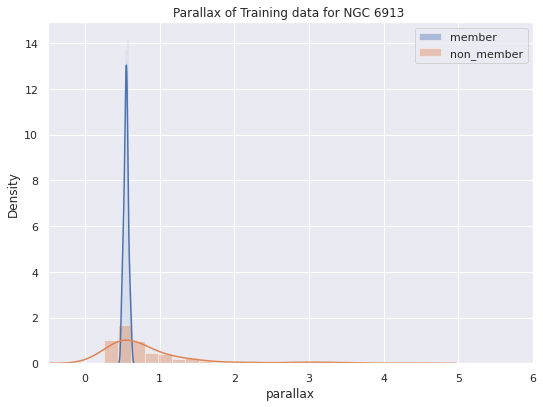

In [62]:
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.xlim(-0.5,6)
plt.title('Parallax of Training data for NGC 6913 ')
plt.legend()
plt.show()

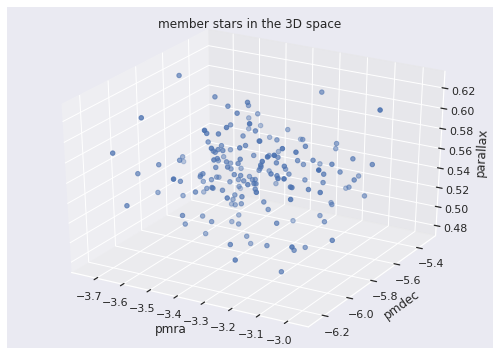

In [63]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


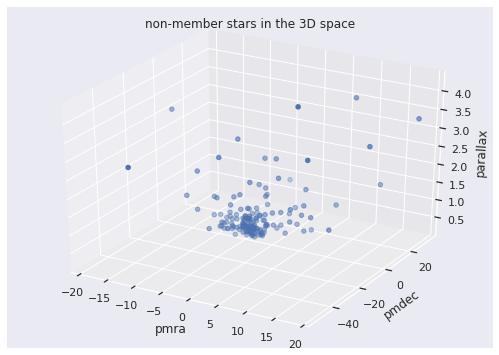

In [64]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


#### Check Feature Importance using Random Forest

In [65]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True)
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [66]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

pmra        0.375566
pmdec       0.337069
parallax    0.287365
dtype: float64

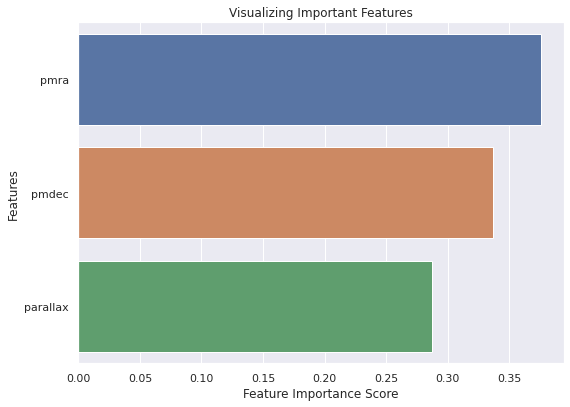

In [67]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Selection and Accuracy Estimate using Test Data

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report

In [69]:
from sklearn.model_selection import train_test_split
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                                targets, 
                                                                                test_size = 0.3, 
                                                                                random_state=258)

In [70]:
def evaluate_model(model):
    test_predict = model.predict(test_features)
    train_predict = model.predict(train_features)

    print('Model Accuracy:')
    print("Precision on training data: %.3f" % precision_score(train_targets, train_predict))
    print("Precision on testing data: %.3f" % precision_score(test_targets, test_predict))
    print('Accuracy on test data: %.3f' % accuracy_score(test_targets, test_predict))


    sns.heatmap(confusion_matrix(test_targets, test_predict), cmap= 'Greens', annot = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report: \n", classification_report(test_targets, test_predict))

#### SVC

In [71]:
from sklearn.svm import SVC

# SVC model
svc_clf = SVC(kernel='rbf', gamma = 'scale', random_state=42)

svc_clf.fit(train_features, train_targets)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Model Accuracy:
Precision on training data: 0.695
Precision on testing data: 0.700
Accuracy on test data: 0.765


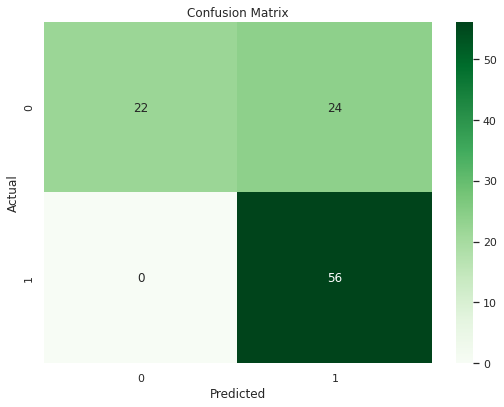

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.48      0.65        46
           1       0.70      1.00      0.82        56

    accuracy                           0.76       102
   macro avg       0.85      0.74      0.74       102
weighted avg       0.84      0.76      0.74       102



In [72]:
evaluate_model(svc_clf)

#### Naive Bayes

Model Accuracy:
Precision on training data: 0.934
Precision on testing data: 0.889
Accuracy on test data: 0.931


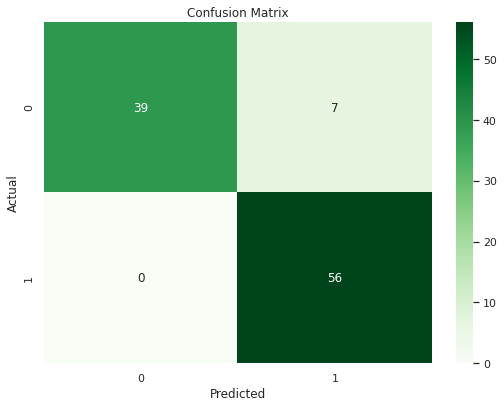

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        46
           1       0.89      1.00      0.94        56

    accuracy                           0.93       102
   macro avg       0.94      0.92      0.93       102
weighted avg       0.94      0.93      0.93       102



In [73]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_features, train_targets)
evaluate_model(gnb)

#### KNN

In [74]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score, GridSearchCV

knn_cv = neighbors.KNeighborsClassifier()
parameter_grid = {'n_neighbors': [1,2,3,4,5,6,7,8]}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_cv, parameter_grid, cv=5, scoring='precision')

#fit model to data
knn_gscv.fit(train_features, train_targets)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=0)

In [75]:
# top performance
print("Top Performance: ", knn_gscv.best_params_)
# score for top_performance
print("Top CV score: ", knn_gscv.best_score_)

Top Performance:  {'n_neighbors': 2}
Top CV score:  0.948909090909091


In [76]:
n_neighbors = 2
knn = neighbors.KNeighborsClassifier(n_neighbors,)
knn.fit(train_features, train_targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.914
Accuracy on test data: 0.922


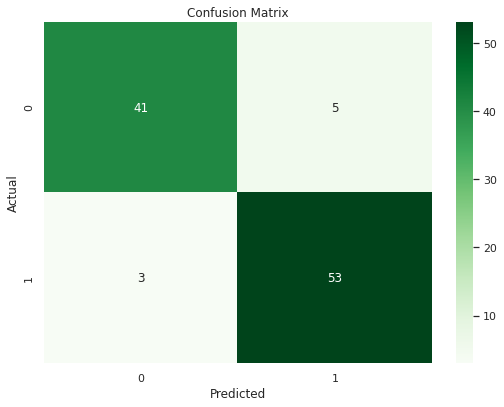

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.89      0.91        46
           1       0.91      0.95      0.93        56

    accuracy                           0.92       102
   macro avg       0.92      0.92      0.92       102
weighted avg       0.92      0.92      0.92       102



In [77]:
evaluate_model(knn)

#### Decision Tree

In [78]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc.fit(train_features, train_targets)
test_predict = dtc.predict(test_features)

In [79]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [80]:
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
np.random.seed(25)
random_states = np.random.choice(range(1,50), size = 10, replace=False)
ccp_alpha = [2**i for i in range(-10,0)]

random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state' : random_states,
               'ccp_alpha': ccp_alpha}

random_grid

{'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'random_state': array([44, 15, 41, 34, 48,  8, 33, 20, 39, 36])}

In [81]:
# base model
dtc = tree.DecisionTreeClassifier()

dtc_random = RandomizedSearchCV(estimator = dtc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [82]:
dtc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [83]:
 dtc_random.best_params_


{'ccp_alpha': 0.00390625,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'random_state': 20}

In [84]:
 dtc_random.best_score_

0.9518065268065268

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.948
Accuracy on test data: 0.961


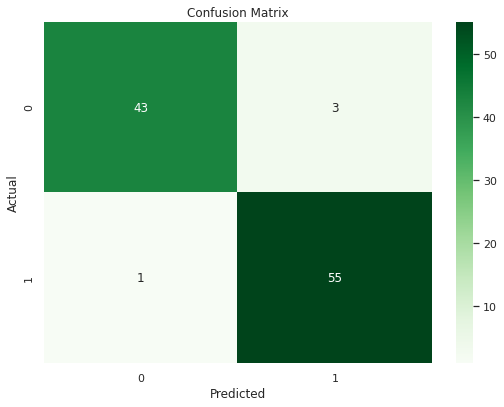

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.96        46
           1       0.95      0.98      0.96        56

    accuracy                           0.96       102
   macro avg       0.96      0.96      0.96       102
weighted avg       0.96      0.96      0.96       102



In [85]:
base_model_dtc = tree.DecisionTreeClassifier()
base_model_dtc.fit(train_features, train_targets)

evaluate_model(base_model_dtc)


Model Accuracy:
Precision on training data: 0.942
Precision on testing data: 0.933
Accuracy on test data: 0.961


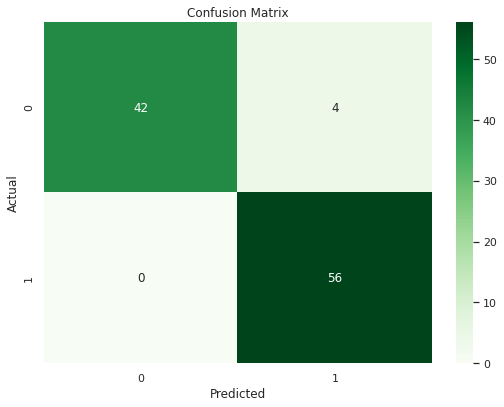

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        46
           1       0.93      1.00      0.97        56

    accuracy                           0.96       102
   macro avg       0.97      0.96      0.96       102
weighted avg       0.96      0.96      0.96       102



In [86]:
best_random_dtc = dtc_random.best_estimator_

evaluate_model(best_random_dtc)


#### Random Forest

In [103]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
ccp_alpha = [2**i for i in range(-10,0)]+[0]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

random_grid

{'bootstrap': [True, False],
 'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5,
  0],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [104]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                    oob_score = True)

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [112]:
rfc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [113]:
rfc_random.best_params_


{'bootstrap': True,
 'ccp_alpha': 0,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}



```
{'bootstrap': True,
 'ccp_alpha': 0,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}
 ```



Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.948
Accuracy on test data: 0.961


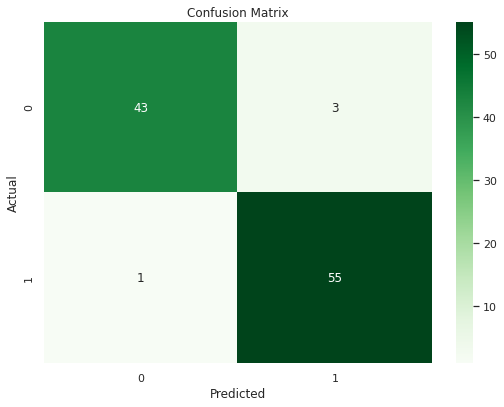

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.96        46
           1       0.95      0.98      0.96        56

    accuracy                           0.96       102
   macro avg       0.96      0.96      0.96       102
weighted avg       0.96      0.96      0.96       102



In [114]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                    oob_score = True)
base_model.fit(train_features, train_targets)

evaluate_model(base_model)


In [115]:
rfc_random.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 0.948
Accuracy on test data: 0.961


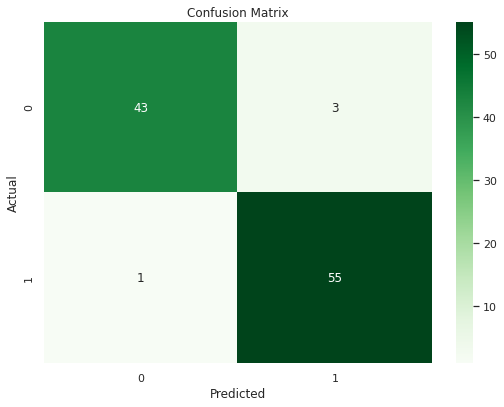

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.96        46
           1       0.95      0.98      0.96        56

    accuracy                           0.96       102
   macro avg       0.96      0.96      0.96       102
weighted avg       0.96      0.96      0.96       102



In [116]:
best_random = rfc_random.best_estimator_

evaluate_model(best_random)


### Prediction for the new stars

In [117]:
# descriptive stats
all_stars_filtered.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_6913_center
count,2.803400e+04,2.803400e+04,2.803400e+04,28034.0,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.000000,28034.0,28034.000000,28031.000000,28031.000000,28034.000000,28034.000000,28034.000000,...,2.761900e+04,27619.000000,27619.000000,27619.000000,27619.000000,28034.000000,27619.000000,27620.000000,27619.000000,1221.000000,1221.000000,28034.000000,1221.000000,1221.000000,1221.000000,28034.000000,28034.000000,28034.000000,28034.000000,12148.000000,12148.000000,12148.000000,12148.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,9616.0,9616.000000,9616.000000,9616.000000,9616.000000,9616.000000,9616.000000,28034.000000,28034.000000,28034.000000,28034.000000
mean,1.635721e+18,2.061172e+18,8.458898e+08,2015.5,305.872420,0.090119,38.539481,0.111966,0.915840,0.123634,13.864596,-2.073974,0.204153,-5.097520,0.227421,-0.032464,0.030744,-0.139561,-0.055515,0.181224,-0.089444,-0.281177,-0.129164,-0.008226,-0.021637,251.442926,7.677677,250.118677,1.324249,3.432866,487.752136,0.291826,7.612590,31.0,14.152946,1.382910,0.027714,0.044293,28.696119,15.780267,...,3.019728e+04,105.996085,327.544525,15.973391,1.448326,0.102126,2.114237,1.056302,1.057902,-16.861485,3.217384,0.321288,5222.358887,3.419328,-0.119165,76.879979,0.685675,323.945433,55.461877,100052.883438,4291.860840,4092.624512,4640.046875,1.830622,1.606607,2.096688,0.919811,0.802921,1.057982,200111.0,3.067470,2.624796,3.375362,7.392673,6.558569,8.226770,0.547339,40.652779,55.793369,0.547287
std,0.000000e+00,2.166701e+15,4.887509e+08,0.0,0.523886,0.087141,0.396763,0.109775,0.783197,0.120321,20.890415,6.271293,0.200804,7.168581,0.231156,0.098490,0.140544,0.103824,0.074207,0.131505,0.078642,0.147043,0.098588,0.112063,0.102685,25.297575,42.751336,25.269308,1.848743,10.442020,3790.343506,0.506854,104.452646,0.0,48.806553,0.095409,0.026425,0.049390,2.809967,1.144634,...,4.833111e+05,6129.104879,335.045227,1.666873,0.185388,0.342405,0.601741,0.421447,0.222254,24.073676,3.622075,1.614611,694.093201,0.548325,0.405811,0.386416,0.419567,0.698200,0.410534,317.498408,661.720093,677.540039,640.731812,0.977696,0.969308,0.986003,0.495166,0.488539,0.503405,0.0,3.912091,3.437303,4.353330,50.739304,45.947376,55.577576,0.183139,80.294138,89.513815,0.183109
min,1.635721e+18,2.057987e+18,2.153750e+05,2015.5,304.961939,0.009945,37.723675,0.011774,0.134849,0.013523,3.00035

In [118]:
# chosing only GAIA stars close to 0.40 degree radius of the center
all_stars_filtered = all_stars_filtered.dropna(subset = feature_columns)
GAIA_target_stars = all_stars_filtered[all_stars_filtered['dist_6913_center'] <= (cantat_radius*2)]

In [119]:
# removing the member stars from GAIA data
GAIA_target_stars = pd.concat([GAIA_target_stars, training_data.drop(columns=['PMemb', 'member']), 
                               training_data.drop(columns=['PMemb', 'member'])]).drop_duplicates(keep=False)

In [120]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [121]:
# train the model again using all the features and targets of the previous dataset
# rfc.fit(features, targets)

In [122]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = best_random.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    14479
1      561
Name: member, dtype: int64

In [145]:
# estimate the membership probability of the stars
GAIA_target_stars['PMemb'] = best_random.predict_proba(new_features)[:,1]
sum(GAIA_target_stars['PMemb'] > 0.5)

561

In [146]:
potentialMember = GAIA_target_stars[GAIA_target_stars['member'] == 1]
len(potentialMember)

561

In [125]:
potentialMember.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_6913_center,member,PMemb
count,5.610000e+02,5.610000e+02,5.610000e+02,561.0,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.0,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,...,559.000000,559.000000,559.000000,561.000000,559.000000,559.000000,559.000000,3.000000,3.000000,561.000000,3.0,3.000000,3.0,561.000000,561.000000,561.000000,561.000000,401.000000,401.000000,401.000000,401.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,394.0,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,561.000000,561.000000,561.000000,561.000000,561.0,561.000000
mean,1.635721e+18,2.061066e+18,8.472731e+08,2015.5,305.715823,0.044027,38.562433,0.053517,0.555676,0.059470,15.314091,-3.373582,0.097876,-5.789827,0.108770,-0.033244,0.036795,-0.154849,-0.056277,0.176099,-0.084886,-0.272915,-0.130318,-0.014046,-0.028631,256.538324,20.046346,255.258467,1.279857,0.502044,269.355591,0.095299,0.817929,31.0,41.750492,1.432772,0.013478,0.042670,29.262032,16.042781,...,540.328552,14.827484,1.364317,0.137255,1.812661,0.885924,0.926737,25.746642,2.453661,0.040998,5000.0,3.500000,0.0,76.828019,0.798924,323.765121,55.533611,100011.149626,4464.255371,4291.743164,4781.234863,2.206141,1.908016,2.649903,1.110006,0.951208,1.338551,200111.0,4.188280,3.723454,4.488814,21.795416,19.717026,23.873831,0.447220,57.387731,91.288740,0.447145,1.0,0.881735
std,0.000000e+00,1.354459e+15,5.084005e+08,0.0,0.339523,0.033632,0.310010,0.041419,0.036474,0.045241,9.439514,0.279492,0.075657,0.248645,0.085149,0.083369,0.137280,0.091739,0.063575,0.123630,0.068032,0.136786,0.099799,0.096740,0.087815,24.679135,67.411116,24.594770,1.631751,3.576254,98.703957,0.169139,2.570803,0.0,83.056000,0.092728,0.010410,0.046474,2.732242,0.977399,...,401.422302,1.762682,0.115961,0.354641,0.603021,0.390400,0.223020,51.624785,2.192018,0.603645,500.0,0.866025,0.0,0.290343,0.286894,0.474187,0.307497,141.056381,593.268616,590.129822,559.704773,0.627009,0.647318,0.512690,0.320247,0.326430,0.260518,0.0,5.078306,4.821367,5.298294,124.870544,112.667648,137.084167,0.107864,36.331433,58.500506,0.107806,0.0,0.150744
min,1.635721e+18,2.058091e+18,9.169710e+05,2015.5,305.227174,0.010781,37.922678,0.011774,0.473988,0.014355,3.033455,-4.590996,0.022819,-6.392413,0.021726,-0.286891,-0.338699,-0.477231,-0.291288,-0.290750,-0.293386,-0.742894,-0.369477,-0.373150,-0.388057,151.000000,0.000000,147.000000,0.000000,-8.593496,95.898674,0.000000,0.000000,31.0,0.343600,1.

In [126]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_6913_center,member
count,1.700000e+02,1.700000e+02,1.700000e+02,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,169.000000,169.000000,169.000000,170.000000,169.000000,169.000000,169.000000,1.000000,1.000000,170.000000,1.0,1.0,1.0,170.000000,170.000000,170.000000,170.000000,145.000000,145.000000,145.000000,145.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,144.0,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0
mean,1.635721e+18,2.061104e+18,8.991247e+08,2015.5,305.916874,0.030140,38.498505,0.036322,0.549987,0.041139,18.595560,-3.380745,0.067076,-5.764726,0.074174,-0.052862,0.047154,-0.138174,-0.051963,0.178949,-0.087508,-0.279096,-0.162469,-0.028793,-0.032876,261.029412,31.388235,259.623529,1.405882,-0.452034,251.052277,0.048083,0.398448,31.0,57.397316,1.461027,0.009230,0.062775,29.729412,16.105882,...,690.067383,14.236567,1.320751,0.176471,1.606532,0.757240,0.849291,-17.989237,5.377616,0.035294,5000.0,3.0,0.0,76.865400,0.633193,323.971153,55.411141,100001.193103,4521.335938,4340.726562,4858.288574,2.151746,1.871649,2.629261,1.076579,0.928603,1.343582,200111.0,4.154220,3.680255,4.482897,15.790257,14.470527,17.109993,0.155467,71.419562,110.971035,0.561765,0.155479,1.0
std,0.000000e+00,3.270528e+14,4.883002e+08,0.0,0.142852,0.021423,0.125399,0.026414,0.031147,0.028844,8.643813,0.162431,0.048570,0.184031,0.055731,0.074475,0.128318,0.103372,0.062765,0.135922,0.061610,0.135682,0.085144,0.094080,0.076245,22.651574,86.893881,22.167718,2.222790,3.340387,79.192787,0.099826,1.263057,0.0,97.824677,0.079588,0.006703,0.040093,2.543762,0.979355,...,393.197235,1.571638,0.072689,0.397521,0.452540,0.271826,0.183238,NaN,NaN,0.460179,NaN,NaN,NaN,0.113765,0.123647,0.190410,0.128638,0.396102,556.623779,550.933777,521.955872,0.770660,0.725869,0.540000,0.391130,0.365506,0.281625,0.0,3.504805,3.357561,3.662597,61.949299,57.375221,66.523674,0.085152,33.970233,51.393213,0.257680,0.085171,0.0
min,1.635721e+18,2.058110e+18,1.723005e+06,2015.5,305.636921,0.011508,38.261299,0.013074,0.479977,0.015596,3.813220,-3.740193,0.025444,-6.255921,0.027417,-0.256366,-0.394684,-0.369383,-0.213974,-0.214332,-0.228630,-0.749702,-0.336544,-0.197922,-0.274328,197.000000,0.000000,196.000000,0.000000,-8.638947,106.939201,0.000000,0.000000,31.0,0.857305,1.293266,0.003151,-0.037380,22.000000

#### Visualization

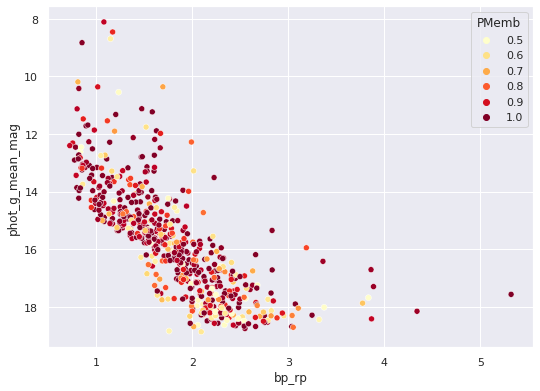

In [127]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'bp_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
cmd.invert_yaxis()

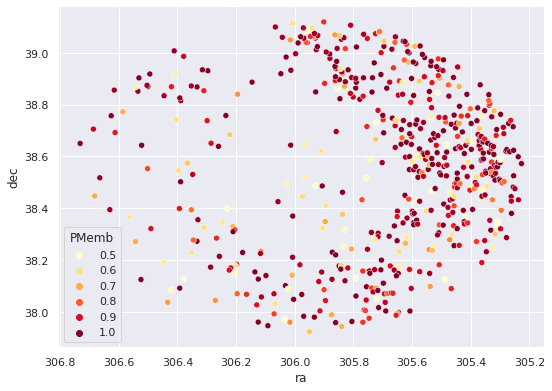

In [128]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
skyplot.invert_xaxis()

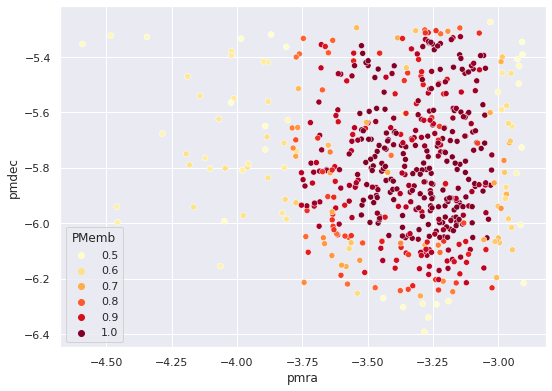

In [129]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )


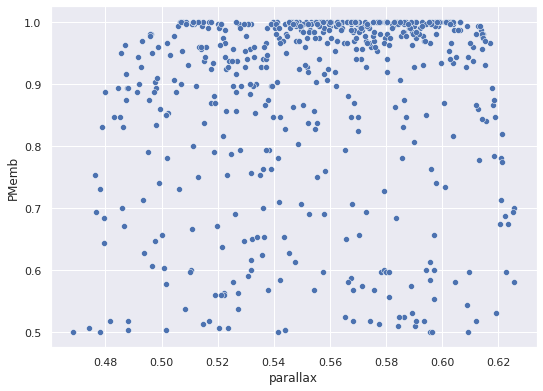

In [130]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )

In [131]:
# saving the files as csv
# all_stars.to_csv('gaia_6913_membership_prob.csv')

potentialMember.to_csv('NGC_6913_membership_prob.csv')


### Comparing the old and new predicted members

In [132]:
# creating subset for the potential member in previous dataset

concatenated = pd.concat([potentialMember.assign(dataset='New_member'), member.assign(dataset='Old_member')])


In [133]:
concatenated.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_6913_center,member,PMemb
count,7.310000e+02,7.310000e+02,7.310000e+02,731.0,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.0,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,728.000000,728.000000,728.000000,731.000000,728.000000,728.000000,728.000000,4.000000,4.000000,731.000000,4.000000,4.000,4.0,731.000000,731.000000,731.000000,731.000000,546.000000,546.000000,546.000000,546.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,538.0,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,731.000000,731.000000,731.000000,731.000000,731.0,731.000000
mean,1.635721e+18,2.061075e+18,8.593316e+08,2015.5,305.762579,0.040798,38.547566,0.049518,0.554353,0.055207,16.077227,-3.375248,0.090713,-5.783989,0.100724,-0.037806,0.039204,-0.150971,-0.055274,0.176762,-0.085496,-0.274353,-0.137795,-0.017476,-0.029618,257.582763,22.683995,256.273598,1.309166,0.280165,265.098938,0.084318,0.720375,31.0,45.389278,1.439343,0.012490,0.047346,29.370725,16.057456,...,575.089172,14.690304,1.354204,0.146375,1.764811,0.856051,0.908758,14.812672,3.184650,0.039672,5000.000000,3.375,0.0,76.836712,0.760382,323.813035,55.505129,100008.505495,4479.414062,4304.750000,4801.699707,2.193879,1.899819,2.645249,1.102471,0.946112,1.339685,200111.0,4.179163,3.711891,4.487231,20.188095,18.312763,22.063431,0.379370,60.650947,95.866018,0.379315,1.0,0.807323
std,0.000000e+00,1.196807e+15,5.039440e+08,0.0,0.316827,0.031756,0.279457,0.039120,0.035368,0.042694,9.358189,0.256985,0.071461,0.235330,0.080591,0.081760,0.135234,0.094761,0.063371,0.126505,0.066562,0.136462,0.097486,0.096266,0.085233,24.281955,72.505172,24.108183,1.785838,3.543596,94.791565,0.157007,2.338956,0.0,86.896721,0.090582,0.009836,0.045839,2.695133,0.977547,...,404.240143,1.737210,0.108999,0.365157,0.577938,0.370153,0.216807,47.486339,2.310990,0.573202,408.248291,0.750,0.0,0.260602,0.267560,0.434131,0.281152,120.924121,583.802063,579.884521,550.514404,0.660100,0.663813,0.517445,0.336599,0.334664,0.264590,0.0,4.705842,4.473758,4.910855,111.536682,100.856606,122.230515,0.160675,36.261881,57.498157,0.160619,0.0,0.226056
min,1.635721e+18,2.058091e+18,9.169710e+05,2015.5,305.227174,0.010781,37.922678,0.011774,0.473988,0.014355,3.033455,-4.590996,0.022819,-6.392413,0.021726,-0.286891,-0.394684,-0.477231,-0.291288,-0.290750,-0.293386,-0.749702,-0.369477,-0.373150,-0.388057,151.000000,0.000000,147.000000,0.000000,-8.638947,95.898674,0.000000,0.000000,31.0,0.343

In [134]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_6913_center,member
count,1.700000e+02,1.700000e+02,1.700000e+02,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,169.000000,169.000000,169.000000,170.000000,169.000000,169.000000,169.000000,1.000000,1.000000,170.000000,1.0,1.0,1.0,170.000000,170.000000,170.000000,170.000000,145.000000,145.000000,145.000000,145.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,144.0,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0
mean,1.635721e+18,2.061104e+18,8.991247e+08,2015.5,305.916874,0.030140,38.498505,0.036322,0.549987,0.041139,18.595560,-3.380745,0.067076,-5.764726,0.074174,-0.052862,0.047154,-0.138174,-0.051963,0.178949,-0.087508,-0.279096,-0.162469,-0.028793,-0.032876,261.029412,31.388235,259.623529,1.405882,-0.452034,251.052277,0.048083,0.398448,31.0,57.397316,1.461027,0.009230,0.062775,29.729412,16.105882,...,690.067383,14.236567,1.320751,0.176471,1.606532,0.757240,0.849291,-17.989237,5.377616,0.035294,5000.0,3.0,0.0,76.865400,0.633193,323.971153,55.411141,100001.193103,4521.335938,4340.726562,4858.288574,2.151746,1.871649,2.629261,1.076579,0.928603,1.343582,200111.0,4.154220,3.680255,4.482897,15.790257,14.470527,17.109993,0.155467,71.419562,110.971035,0.561765,0.155479,1.0
std,0.000000e+00,3.270528e+14,4.883002e+08,0.0,0.142852,0.021423,0.125399,0.026414,0.031147,0.028844,8.643813,0.162431,0.048570,0.184031,0.055731,0.074475,0.128318,0.103372,0.062765,0.135922,0.061610,0.135682,0.085144,0.094080,0.076245,22.651574,86.893881,22.167718,2.222790,3.340387,79.192787,0.099826,1.263057,0.0,97.824677,0.079588,0.006703,0.040093,2.543762,0.979355,...,393.197235,1.571638,0.072689,0.397521,0.452540,0.271826,0.183238,NaN,NaN,0.460179,NaN,NaN,NaN,0.113765,0.123647,0.190410,0.128638,0.396102,556.623779,550.933777,521.955872,0.770660,0.725869,0.540000,0.391130,0.365506,0.281625,0.0,3.504805,3.357561,3.662597,61.949299,57.375221,66.523674,0.085152,33.970233,51.393213,0.257680,0.085171,0.0
min,1.635721e+18,2.058110e+18,1.723005e+06,2015.5,305.636921,0.011508,38.261299,0.013074,0.479977,0.015596,3.813220,-3.740193,0.025444,-6.255921,0.027417,-0.256366,-0.394684,-0.369383,-0.213974,-0.214332,-0.228630,-0.749702,-0.336544,-0.197922,-0.274328,197.000000,0.000000,196.000000,0.000000,-8.638947,106.939201,0.000000,0.000000,31.0,0.857305,1.293266,0.003151,-0.037380,22.000000

In [135]:
concatenated.dataset.value_counts()

New_member    561
Old_member    170
Name: dataset, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

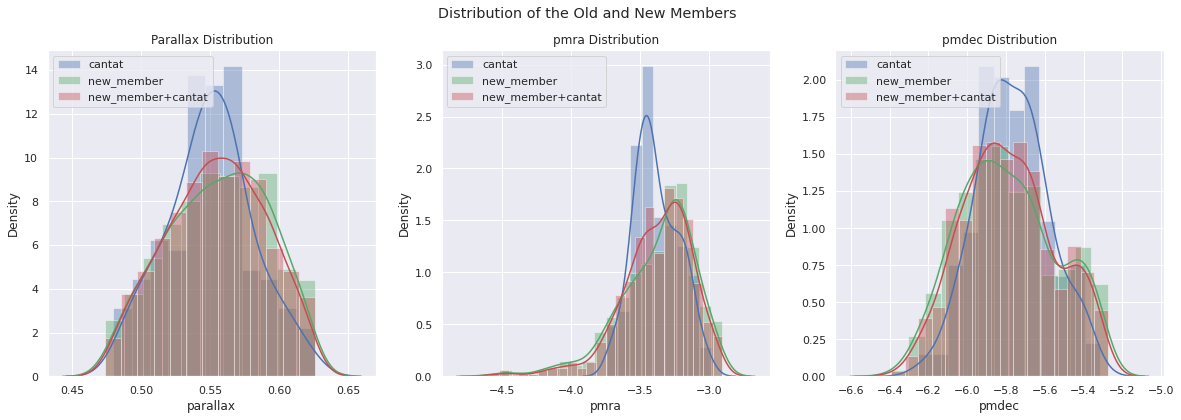

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Distribution of the Old and New Members')


sns.distplot(member['parallax'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[0])
sns.distplot(potentialMember['parallax'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[0])
sns.distplot(concatenated['parallax'], color = 'r', ax=axes[0], kde=True,
             label = 'new_member+cantat')
axes[0].set_title('Parallax Distribution')
axes[0].legend()

sns.distplot(member['pmra'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[1])
sns.distplot(potentialMember['pmra'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[1])
sns.distplot(concatenated['pmra'], color = 'r', ax=axes[1], kde=True,
             label = 'new_member+cantat')
axes[1].set_title('pmra Distribution')
axes[1].legend()

sns.distplot(member['pmdec'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[2])
sns.distplot(potentialMember['pmdec'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[2])
sns.distplot(concatenated['pmdec'], color = 'r', ax=axes[2], kde=True,
             label = 'new_member+cantat')
axes[2].set_title('pmdec Distribution')
axes[2].legend()

plt.show()


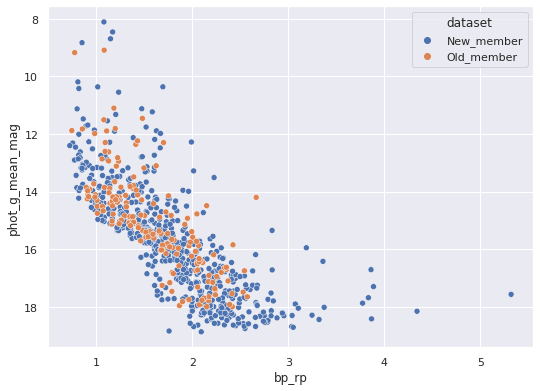

In [137]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset')
cmd.invert_yaxis()

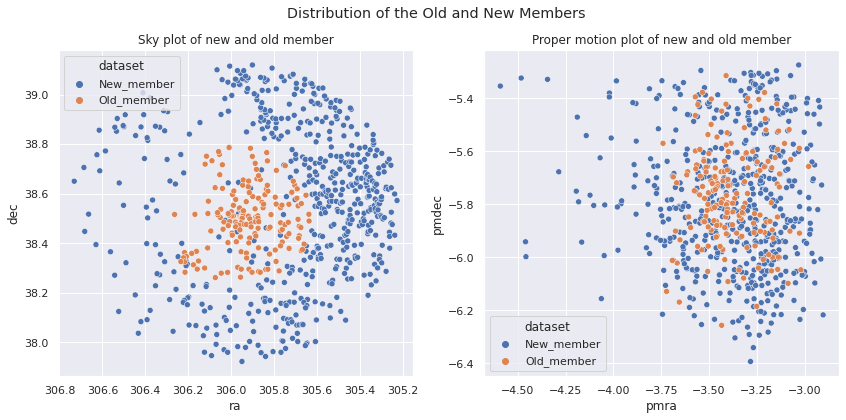

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Distribution of the Old and New Members')

skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                hue='dataset', ax=axes[0])
skyplot.invert_xaxis()
axes[0].set_title('Sky plot of new and old member')

# proper motion plot
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', ax=axes[1])
axes[1].set_title('Proper motion plot of new and old member')

plt.show()

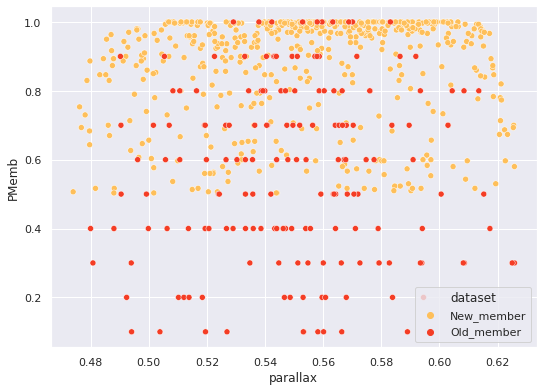

In [139]:
# parallax vs PMemb plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  hue = 'dataset',
                      palette='YlOrRd', data = concatenated )

In [140]:
# pd_prof.ProfileReport(potentialMember)

In [141]:
#files.download('NGC_6913_cantat.csv')

#files.download('NGC_6913_membership_prob.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


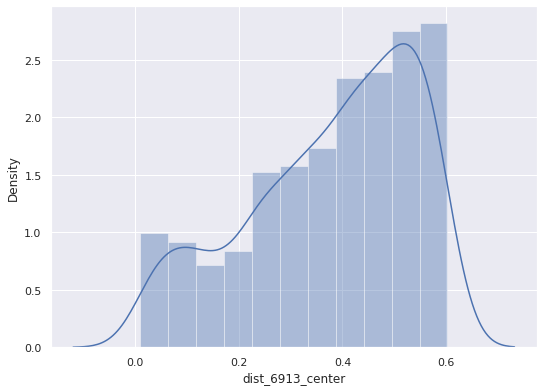

In [142]:
sns.distplot(concatenated['dist_6913_center'])

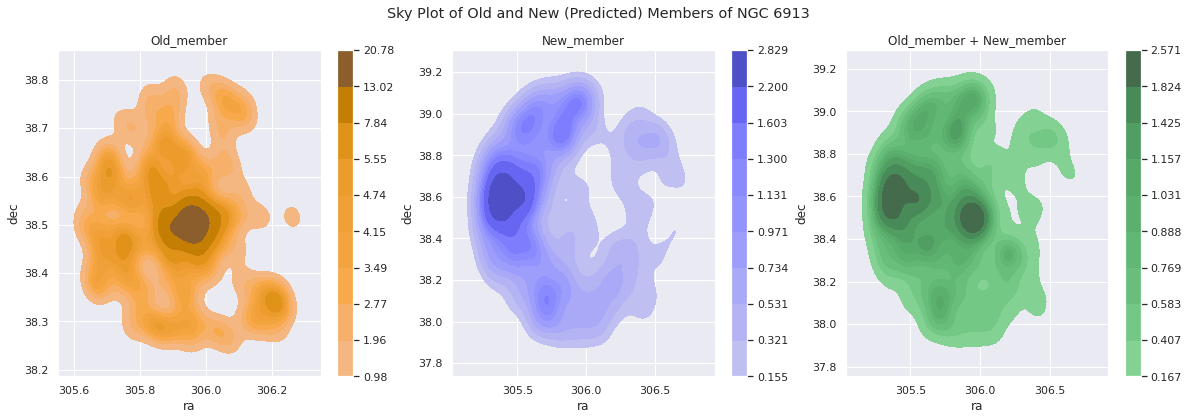

In [143]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Sky Plot of Old and New (Predicted) Members of NGC 6913')

sns.kdeplot(x='ra', y='dec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='ra', y='dec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='ra', y='dec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

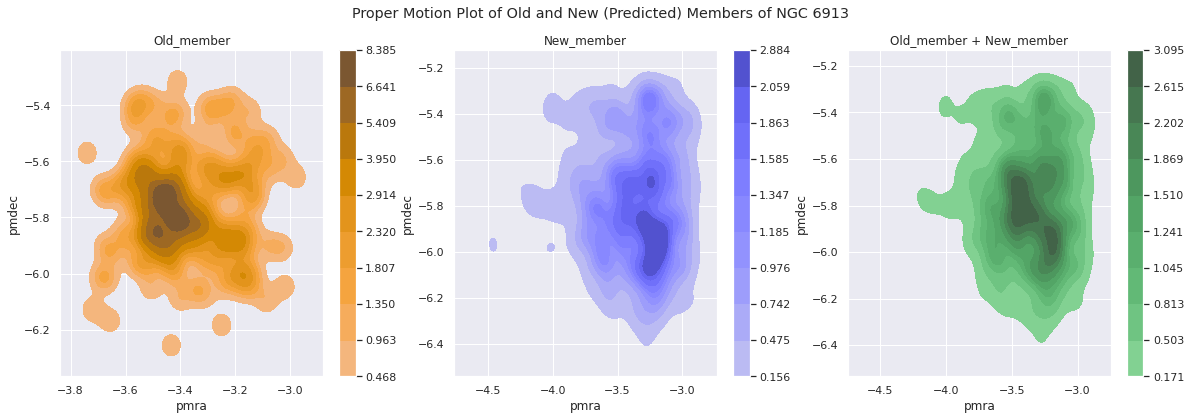

In [144]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Proper Motion Plot of Old and New (Predicted) Members of NGC 6913')

sns.kdeplot(x='pmra', y='pmdec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='pmra', y='pmdec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='pmra', y='pmdec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

In [147]:
#files.download('NGC_6913_cantat.csv')

potentialMember.to_csv('NGC_6913_additional_member_prob.csv')
concatenated.to_csv('NGC_6913_all_member_prob.csv')

files.download('NGC_6913_all_member_prob.csv')
# column 'dataset': Old_member, New_member
# column 'member': 0 and 1
# column 'PMemb': decimal values between 0 to 1

files.download('NGC_6913_additional_member_prob.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>